In [ ]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


In [1]:
import os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from simulai.regression import DenseNetwork
from simulai.models import DeepONet
from simulai.optimization import Optimizer

In [2]:
data_path = os.environ['DATASET_PATH']
data_path

'/home/jalmeida/Datasets/Lotka-Volterra/Lotka_Volterra_dataset.npz'

In [3]:
datasets = np.load(data_path)

In [4]:
input_dataset_raw = datasets['input_dataset']
output_dataset_raw = datasets['diff_output_dataset']
time_raw = datasets['time']

In [5]:
time_interval = [0, 120]
n_cases = 200
n_cases_test = 20
n_sensors = 100
n_time_samples = 50
latent_dim = 500
n_vars = 2
activation = "tanh"
layers_units = [50, 50, 50]
n_inputs = 1
lr = 1e-3
lambda_1 = 0.0
lambda_2 = 1e-5
n_epochs = 10000

In [6]:
time_ = time_raw[time_raw <= time_interval[-1]]
time_indices = sorted(np.random.choice(time_.shape[0], n_time_samples))

In [7]:
time = time_[time_indices]

In [8]:
output_dataset_train = output_dataset_raw[:,:, :n_cases]
output_dataset_test = output_dataset_raw[:,:,n_cases:]

input_dataset_train = input_dataset_raw[:, :n_cases]
input_dataset_test = input_dataset_raw[:,n_cases:]

In [9]:
output_dataset_time_sampled = output_dataset_train[time_indices]
input_dataset_sensor_sampled = input_dataset_train[time_indices][:,None,:]
time_sampled = time_raw[time_indices]
verify_case_index = 100

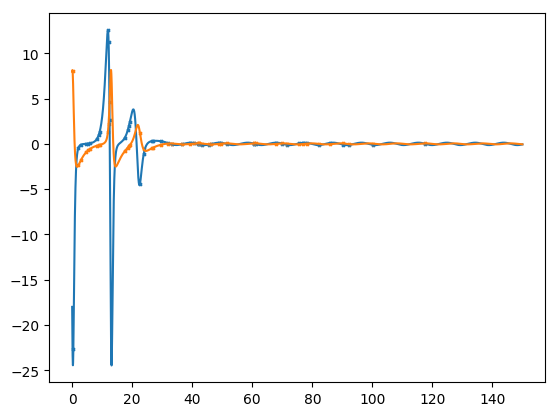

In [10]:
plt.plot(time_raw, output_dataset_train[:, 0, verify_case_index])
plt.plot(time_raw, output_dataset_train[:, 1, verify_case_index])
plt.scatter(time, output_dataset_time_sampled[:, 0, verify_case_index], s=4, marker='x')
plt.scatter(time, output_dataset_time_sampled[:, 1, verify_case_index], s=4, marker='x')
plt.show()

In [11]:
output_target = output_dataset_time_sampled.transpose(0, 2, 1).reshape(n_cases*n_time_samples, -1)

In [12]:
input_branch = input_dataset_sensor_sampled.transpose(0, 2, 1).reshape(n_cases*n_time_samples, -1)

In [13]:
input_trunk = np.tile(time[:,None], (n_cases, 1))

In [14]:
input_data = np.hstack([input_branch, input_trunk])

In [15]:
# Configuration for the fully-connected network
config_net = {
                'layers_units': [50, 50, 50],
                'activations': activation,
                'input_size': input_data.shape[1],
                'output_size': output_target.shape[1],
                'name': 'Lotka-Volterra'
             }

# Instantiating and training the surrogate model
net = DenseNetwork(**config_net)

net.summary()

optimizer_config = {'lr': lr}

# Maximum derivative magnitudes to be used as loss weights
maximum_values = (1/np.linalg.norm(output_target, 2, axis=0)).tolist()

params = {'lambda_1': lambda_1, 'lambda_2': lambda_2, 'weights': maximum_values}

Summary of the network properties:
Linear operations layers:

[Linear(in_features=2, out_features=50, bias=True), Linear(in_features=50, out_features=50, bias=True), Linear(in_features=50, out_features=50, bias=True), Linear(in_features=50, out_features=2, bias=True)]
Activations layers:

[Tanh(), Tanh(), Tanh(), Identity()]
Initializations at each layer:

['xavier', 'xavier', 'xavier', 'xavier']


In [16]:
optimizer = Optimizer('adam', params=optimizer_config)
optimizer.fit(op=net, input_data=input_data, target_data=output_target,
              n_epochs=n_epochs, loss="wrmse", params=params)

Using CPU.
loss: 0.056346885859966285